# Various quantification scripts for confocal

In [1]:
import os
import tifffile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops


In [2]:
# Functions

def create_binarized_images(experiment, organized_data):
    # Given a key (experiment) and a dictionary of 
    # experiments (organized_data),
    # return a binary image with
    # color channels combined into binarized image
    
    binarized_images = []
    for channel in organized_data[experiment]:
        file = os.path.join(segs_dir, channel)
        data = tifffile.imread(os.path.normpath(file))[128:,:]
        binarized_images.append(data>0)
    combo_im = np.logical_or(binarized_images[0], binarized_images[1])

    return combo_im


In [3]:
# Define variables

mpp = 0.0992 #microns per pixel


In [4]:
# Load cell segmentations and organize by image

segs_dir = os.path.normpath(r'ConfocalData')

# Organize filenames by image stack
organized_data = {}
for im in os.listdir(segs_dir):
    experiment_name = '_'.join(im.split('_')[0:2])
    if experiment_name not in organized_data.keys():
        organized_data[experiment_name] = []
    organized_data[experiment_name].append(im)


## Show images

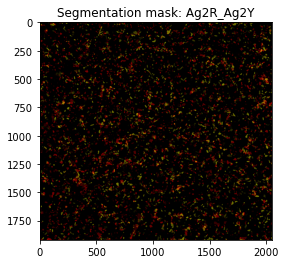

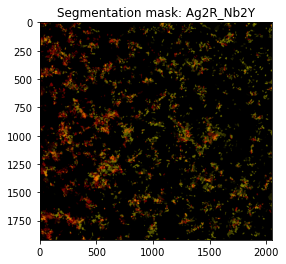

In [5]:
# Iterate over experiments, and show a color combined image

for experiment in organized_data.keys():
    # Initialize empty RGB image
    color_im = np.zeros((1920, 2048, 3))
    for channel in organized_data[experiment]:
        file = os.path.join(segs_dir, channel)
        data = tifffile.imread(os.path.normpath(file))[128:,:]
        if '_R' in channel:
            color_im[:,:,0] += (data / (np.max(data)))
        elif '_Y' in channel:
            color_im[:,:,0] += (data / (np.max(data)))
            color_im[:,:,1] += (data / (np.max(data)))

    color_im /= (np.max(color_im))
    plt.figure()
    plt.imshow(color_im)
    plt.title(f'Segmentation mask: {experiment}')


## Packing fraction

In [6]:
# Calculate packing fraction at image level

packing_fraction_organized_data = {}

for experiment in organized_data.keys():
    # Combine color channels into binarized image
    combo_im = create_binarized_images(experiment, organized_data)
    
    # Compute packing fraction as (area with cells) / (image area)
    packing_fraction_organized_data[experiment] = [np.sum(combo_im) / (1920*2048)]

# Convert to DataFrame
pack_frac_df = pd.DataFrame.from_dict(packing_fraction_organized_data)


Text(0.5, 1.0, 'Cellular Packing Fraction')

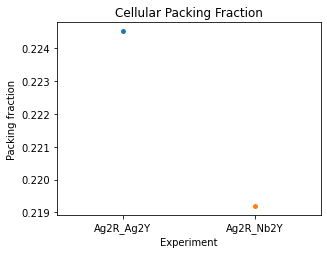

In [7]:
# Plot data

fig, ax = plt.subplots(figsize=(12/2.54, 9/2.54))
ax=sns.swarmplot(x="variable", y="value", data=pack_frac_df.melt())
plt.xlabel('Experiment')
plt.ylabel('Packing fraction')
plt.title('Cellular Packing Fraction')


## Mean free path

In [8]:
# Functions

def get_free_path_lengths(image):
    # Given a binary image,
    # returns a list of all uninterrupted horizontal path lengths
    
    # initialize container for path lengths
    path_lengths = []
    
    # iterate over each row
    for row in image:
        new_start = True
        cur_path_length = 0
        
        # iterate over each pixel in row
        for pixel in row:
            if new_start == True:
                if pixel == 0:
                    new_start = False
                    cur_path_length += 1
            elif new_start == False:
                if pixel == 0:
                    cur_path_length += 1
                else: # if pixel is not zero, finish count and start a new one
                    path_lengths.append(cur_path_length)
                    cur_path_length = 0
                    new_start = True

    return path_lengths


In [9]:
# Calculate mean free paths at image level

mean_free_path_organized_data = {}

for experiment in organized_data.keys():
    # Combine color channels into binarized image
    combo_im = create_binarized_images(experiment, organized_data)
    
    # Calculate mean free path
    mean_free_path_organized_data[experiment] = [mpp*np.mean(get_free_path_lengths(combo_im.T))]

# Convert to DataFrame
binned_mean_free_df = pd.DataFrame.from_dict(mean_free_path_organized_data)


Text(0.5, 1.0, 'Mean Free Path')

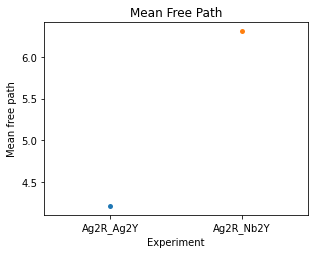

In [10]:
# Plot data

fig, ax = plt.subplots(figsize=(12/2.54, 9/2.54))
ax=sns.swarmplot(x="variable", y="value", data=binned_mean_free_df.melt())
plt.xlabel('Experiment')
plt.ylabel('Mean free path')
plt.title('Mean Free Path')


## Cluster area

In [11]:
# Calculate cluster sizes in image

cluster_sizes = {}
cluster_sizes_means = {}

for experiment in organized_data.keys():
    # Combine color channels into binarized image
    combo_im = create_binarized_images(experiment, organized_data)
    
    # Find dicrete clusters using skimage label
    im_labels = label(combo_im)
    im_regions = regionprops(im_labels)
    
    # Get average size of detected clusters
    cluster_sizes[experiment] = [reg.area for reg in im_regions]
    cluster_sizes_means[experiment] = [mpp*mpp*np.mean(cluster_sizes[experiment])]

# Convert to DataFrame
binned_cluster_mean_free_df = pd.DataFrame.from_dict(cluster_sizes_means)


Text(0.5, 1.0, 'Cellular Cluster Area')

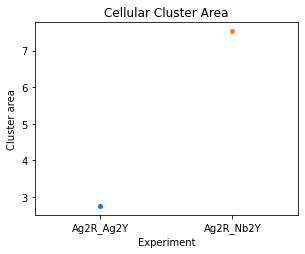

In [12]:
# Plot data

fig, ax = plt.subplots(figsize=(12/2.54, 9/2.54))
ax=sns.swarmplot(x="variable", y="value", data=binned_cluster_mean_free_df.melt())
plt.xlabel('Experiment')
plt.ylabel('Cluster area')
plt.title('Cellular Cluster Area')


## Cell densities

In [13]:
# Get total cell densities per image

imsize = 1920*2048*mpp*mpp

cell_density_binned = {}

for experiment in organized_data.keys():
    for channel in organized_data[experiment]:
        # Load data
        file = os.path.join(segs_dir, channel)
        data = tifffile.imread(os.path.normpath(file))[128:,:]
        
        # Find discrete cells using skimage label
        label_img = label(data)
        regions = regionprops(label_img)

        # Initialize list with element zero
        if experiment not in cell_density_binned.keys():
            cell_density_binned[experiment] = [0]

        # Calculate density as number of cells / imsize
        cell_density_binned[experiment][0] += len(regions)/imsize

# Convert to DataFrame
cell_density_binned_df = pd.DataFrame.from_dict(cell_density_binned) 


Text(0.5, 1.0, 'Cell Density')

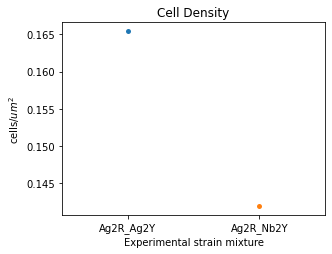

In [14]:
# Plot data

fig, ax = plt.subplots(figsize=(12/2.54, 9/2.54))
ax=sns.swarmplot(x="variable", y="value", data=cell_density_binned_df.melt())
plt.xlabel('Experimental strain mixture')
plt.ylabel('cells/$um^2$')
plt.title('Cell Density')
